# TTC Subway Delay Time Prediction

* In this notebook we are going to use ttc subway data for the year 2023 to predict the delay time of the subway.
* For the prediction purpose we are using the Linear Regression to build the ML model.
* The data set that is used in this notebook is provided by Toronto Transit Commission(TTC) available on the [Toronto Open Data Portal]("https://open.toronto.ca/dataset/ttc-subway-delay-data/")

Data Set Columns Description: <br>
1. __Date__: The Date(YYYY/MM/DD) date on which the delay occurred
2. __Time__: The Hour : Minute of the day
3. __Day__: The Day of the week
4. __Station__: The Subway Station Name
5. __Code__: The TTC Delay Code
6. __Min Delay__: The delay time in minutes
7. __Min Gap__: The time length(in minutes) between trains
8. __Bound__: The direction of train dependant on the line
9. __Line__: TTC subway line i.e. YU, BD, SHP, and SRT
10. __Vehicle__: TTC Train Number

*<b>note:</b> We will be only using Line 1 i.e YU and Line 2 i.e BD lines as SHP & SRT lines are closed.

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import requests
from bs4 import BeautifulSoup

from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import joblib

## Reading the excel file of the data set

In [2]:
df = pd.read_excel('data/ttc-subway-delay-data-2023.xlsx')
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2023-01-01,02:22,Sunday,MUSEUM STATION,MUPAA,3,9,S,YU,5931
1,2023-01-01,02:30,Sunday,KIPLING STATION,MUIS,0,0,E,BD,5341
2,2023-01-01,02:33,Sunday,WARDEN STATION,SUO,0,0,W,BD,0
3,2023-01-01,03:17,Sunday,KEELE STATION,MUIS,0,0,NaN,BD,0
4,2023-01-01,07:16,Sunday,BATHURST STATION,MUIS,0,0,NaN,BD,0


In [3]:
df_temp = df.copy()

In [4]:
print(f"No. of rows: {df.shape[0]}")
print(f"No. of cols: {df.shape[1]}")

No. of rows: 22949
No. of cols: 10


In [5]:
df.describe()

,Min Delay,Min Gap,Vehicle
count,22949.000000,22949.000000,22949.000000
mean,2.970892,4.370387,3028.186152
std,9.295641,10.353832,2742.364641
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5055.000000
75%,4.000000,8.000000,5526.000000
max,423.000000,428.000000,9541.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22949 entries, 0 to 22948
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       22949 non-null  datetime64[ns]
 1   Time       22949 non-null  object        
 2   Day        22949 non-null  object        
 3   Station    22949 non-null  object        
 4   Code       22949 non-null  object        
 5   Min Delay  22949 non-null  int64         
 6   Min Gap    22949 non-null  int64         
 7   Bound      14423 non-null  object        
 8   Line       22901 non-null  object        
 9   Vehicle    22949 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 1.8+ MB


<p style="font-size: 17px; letter-spacing:1px; font-family: Times, serif;">As you can see there are <b>22949</b> records and <b>10</b> columns in our dataset. Out of these 10 columns <code>"Min Delay"</code><br> is our Dependent Variabe(Y) which we are going to predict.</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: Times, serif;">Now let us look at all the Independent Variables(X) and try to understand the data.</p>

## Independent Feature: _Date_

In [7]:
df['Date'].head()

0   2023-01-01
1   2023-01-01
2   2023-01-01
3   2023-01-01
4   2023-01-01
Name: Date, dtype: datetime64[ns]

<p style="font-size: 17px; letter-spacing:1px; font-family: Times, serif;">
If we look at the date, it is not much helpful for the prediction but if we extract the <code>month</code> from the date and make it as a feature, then it might be helpful for the prediction.
</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: Times, serif;">So, let's extract month feature from the date.</p>

In [8]:
# Extracting Month from the date
df['Month'] = df['Date'].dt.month

# Dropping the date column as it is no longer needed
df.drop(columns=['Date'], inplace=True)

## Independent Feature: _Time_

In [9]:
df['Time'].head()

0    02:22
1    02:30
2    02:33
3    03:17
4    07:16
Name: Time, dtype: object

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
If we look at the Time, it is not much helpful for the prediction but if we extract the <code>divisions of the day</code>
from the time and make it as a feature, then it might be helpful for the prediction.
</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;"> Divisions of the Day:</p>
<ol style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <li>Morning   - <i>5 A.M to 11:59 AM</i></li>
    <li>Afternoon - <i>12:00 P.M to 4:59 PM</i></li>
    <li>Evening   - <i>5:00 P.M to 8:59 PM</i></li>
    <li>Night     - <i>9:00 P.M to 4:59 AM</i></li>
</ol>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">So, let's extract divisions feature from the time.</p>

In [10]:
# First We have to convert date column from object to DateTime object
def convert_time_to_division(time):
    if ((time > 21) & (time <= 24) or (time >= 0) & (time <= 4)):
        t = 'night'
    elif (time > 4) & (time <= 12):
        t = 'morning'
    elif (time > 12) & (time <= 17):
        t = 'afternoon'
    else:
        t = 'evening'
    
    return t

In [11]:
df['Time'] =  df['Time'].apply(pd.Timestamp)
df['Time'] = df['Time'].dt.hour.map(convert_time_to_division)

In [12]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month
0,night,Sunday,MUSEUM STATION,MUPAA,3,9,S,YU,5931,1
1,night,Sunday,KIPLING STATION,MUIS,0,0,E,BD,5341,1
2,night,Sunday,WARDEN STATION,SUO,0,0,W,BD,0,1
3,night,Sunday,KEELE STATION,MUIS,0,0,NaN,BD,0,1
4,morning,Sunday,BATHURST STATION,MUIS,0,0,NaN,BD,0,1


## Independent Feature: _Day_

In [13]:
print(f"No. of Null Values in Day column: {df['Day'].isnull().sum()}")

No. of Null Values in Day column: 0


In [14]:
df['Day'].unique()

array(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday'], dtype=object)

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Day has all 7 days of the week and there's no null values.</p>

## Independent Feature: _Station_

In [15]:
print(f"No. of Null Values in Station column: {df.Station.isnull().sum()}")

No. of Null Values in Station column: 0


In [16]:
# Printing the names of all the Subway Stations
df.Station.unique()

array(['MUSEUM STATION', 'KIPLING STATION', 'WARDEN STATION',
       'KEELE STATION', 'BATHURST STATION', 'JANE STATION',
       'WOODBINE STATION', 'VAUGHAN MC STATION', 'GREENWOOD STATION',
       'ROYAL YORK STATION', 'DONLANDS STATION', 'EGLINTON STATION',
       'SHEPPARD WEST STATION', 'ISLINGTON STATION', 'FINCH STATION',
       'DUNDAS WEST STATION', 'DAVISVILLE STATION',
       'PIONEER VILLAGE STATIO', 'SHERBOURNE STATION', 'KING STATION',
       'ST GEORGE YUS STATION', 'BAY STATION', 'YONGE BD STATION',
       'KENNEDY BD STATION', 'YONGE-UNIVERSITY AND B',
       'KENNEDY SRT STATION TO', 'UNION STATION', 'ST CLAIR STATION',
       'LAWRENCE STATION', 'DON MILLS STATION', 'MCCOWAN STATION',
       'HIGHWAY 407 STATION', 'LANSDOWNE STATION', 'WILSON STATION',
       'COLLEGE STATION', 'EGLINTON WEST STATION', 'ST GEORGE BD STATION',
       'BLOOR STATION', 'COXWELL STATION', 'CHRISTIE STATION',
       'DUNDAS STATION', 'SPADINA BD STATION', 'QUEEN STATION',
       'SUMMERHI

In [17]:
print(f"Number of subway stations in the dataset: {len(df.Station.unique())}")

Number of subway stations in the dataset: 366


<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
We can see that there are 366 subway stations int the Station column but if we refer to this <a href="https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations">WikipediA page</a> of TTC, <br>"The subway system encompasses three lines and 70 stations" only.
So we need to clean the Station column thoroughly.</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Also, we are using only Line 1 and Line 2 Stations as Line 3 &amp; 4 are no longer in usage as of 10th Feb 2024. So, we need to remove the stations which are of Line 1 and Line 2
</p>

### Scraping Station Names from the Wikipedia Page

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
To correctly identify the 70 Stations, first we need get all the 70 subway stations from somewhere.
</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    For getting all the 70 stations, we will scrape all the subway station names from this <a href="https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations">WikipediA page</a> of TTC.<br>
    For scraping the webpage we will use <code>BeautifulSoup</code> library.
</p>

In [18]:
# Getting the response from the WikipediA Page
wiki_url = "https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations"
response = requests.get(wiki_url)

In [19]:
# Creating the Soup object with the webpage's response html
soup = BeautifulSoup(response.text, 'html.parser')
soup.title

<title>List of Toronto subway stations - Wikipedia</title>

In [20]:
# Finding all the html tables
html_tables = soup.find_all('table')

# Extracting the 2nd html table which contains stations names
stations_table = html_tables[1]

# Extracting the first column of the table having names
all_th = stations_table.find_all('th')

# Extracting the value from <a> tag
subway_stations = [s.upper() for s in (th.find('a').text for th in all_th[10:])]

# Removing the dot "." from the names
subway_stations = [str(s).replace(".","") for s in subway_stations]

# Printing the names of stations having "YONGE" in their name
print(f"Stations having YONGE in it: {list(filter(lambda s: 'YONGE' in s, subway_stations))}")

#removing the word "YONGE" from the station names
subway_stations = [s1.replace("–","") for s1 in (str(s).replace('YONGE', "") for s in subway_stations)]

# Removing the dot "'" from the names
subway_stations = [str(s).replace("'","") for s in subway_stations]

subway_stations.sort()

Stations having YONGE in it: ['SHEPPARD–YONGE', 'BLOOR–YONGE']


### Segregating Line 1 and Line 2 Stations

In [21]:
# Extracting all the Table Rows (TRs) from the html table
all_tr = stations_table.find_all('tr')

# Extracting Stations
line1_stations = []
line2_stations = []
for tr in all_tr[1:]:
    for span in tr.find_all('td')[0].find_all('span'):
        # Checking for Line 1 from all the spans
        if ('Line 1' in span.find('a').attrs['title']):
            line1_stations.append(tr.find('th').find('a').text)
        
        # Checking for Line 2 from all the spans
        if ('Line 2' in span.find('a').attrs['title']): # Not using elif because a station can be in 2 lines
            line2_stations.append(tr.find('th').find('a').text)

In [22]:
print(f'No. of Stations in line 1: {len(line1_stations)}')
print(f'No. of Stations in line 2: {len(line2_stations)}')

No. of Stations in line 1: 38
No. of Stations in line 2: 31


In [23]:
# Cleaning the values of line1 and line 2 station list
line1_stations = [
    s.replace('\'','').upper() for s in 
        (s.replace("–","") for s in 
             ((str(s).replace('YONGE', "") for s in 
                   (str(s).replace(".","") for s in  
                        (str(s).replace(".","") for s in line1_stations)))))]

line2_stations = [
    s.replace('\'','').upper() for s in 
        (s.replace("–","") for s in 
             ((str(s).replace('YONGE', "") for s in 
                   (str(s).replace(".","") for s in  
                        (str(s).replace(".","") for s in line2_stations)))))]

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Now that we have scraped all the working stations we will clean the Station column in our data sets.
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Firstly we will remove all the unwanted symbols from the station names. <br>
We will only consider delay time that occurred on the station for other's station names are not consistent
</p>

In [24]:
df1 = df.copy()

In [25]:
# Removing "YONGE" from the station names
df.Station = df.Station.map(lambda s: str(s).replace("YONGE",""))

# Removing "." from the station names
df.Station = df.Station.map(lambda s: str(s).replace(".",""))

# Removing "'" from the station names
df.Station = df.Station.map(lambda s: str(s).replace("'",""))

# Removing "'" from the station names
df.Station = df.Station.map(lambda s: str(s).replace("-",""))

# Replacing STAITON(wrongly typed) with STATION
df['Station'] = df.Station.apply(lambda s: s.replace('STAITON','').strip())


# Removing "STATION" keyword from the Station names
df['Station'] = df.Station.map(lambda s: f"{' '.join(s.split(' ')[ :-1]).strip()}" if 'STATIO' in s else s)

# Creating at_station column with values 0 & 1, 1 means at the station
df['at_station'] = df.Station.map(lambda s: 1 if str(s) in subway_stations else 0)

In [26]:
# Checking which are the stations that is not included in the delay "at station"
delay_stations = df.loc[df['at_station'] == 1]['Station'].unique()
for station in subway_stations: 
    if station not in delay_stations:
        print(station)

NORTH YORK CENTRE
VAUGHAN


In [27]:
# checking if any row has a north york station or not
df[df.Station.str.contains("NORTH YORK")].head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month,at_station
97,morning,Tuesday,NORTH YORK CTR,PUOPO,3,6,S,YU,5736,1,0
100,morning,Tuesday,NORTH YORK CTR,PUOPO,5,8,S,YU,5741,1,0
112,afternoon,Tuesday,NORTH YORK CTR,PUOPO,5,8,S,YU,5886,1,0
160,morning,Wednesday,NORTH YORK CTR,MUIS,0,0,S,YU,0,1,0
710,night,Friday,NORTH YORK CTR,MUIS,0,0,NaN,YU,0,1,0


In [28]:
# changing NORTH YORK CTR to NORTH YORK CENTRE
df.loc[df['Station'] == 'NORTH YORK CTR', ['Station']] = 'NORTH YORK CENTRE'

# changing at_station value to 1
df.loc[df['Station'] == 'NORTH YORK CENTRE', ['at_station']] = 1

In [29]:
# checking if any row has a VAUGHAN station or not
df[df.Station.str.contains("VAUGHAN")].head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month,at_station
7,morning,Sunday,VAUGHAN MC,TUNOA,6,12,S,YU,5451,1,0
45,night,Monday,VAUGHAN MC,SUDP,0,0,S,YU,5801,1,0
47,night,Monday,VAUGHAN MC,SUDP,0,0,S,YU,5976,1,0
109,afternoon,Tuesday,VAUGHAN MC,MUI,3,6,S,YU,6106,1,0
242,evening,Thursday,VAUGHAN MC,MUI,0,0,NaN,YU,5543,1,0


In [30]:
# changing at_station value to 1
df.loc[df['Station'] == 'VAUGHAN MC', ['at_station']] = 1

# changing VAUGHAN MC to VAUGHAN
df.loc[df['Station'] == 'VAUGHAN MC', ['Station']] = 'VAUGHAN'

In [31]:
print(f"Number of delays which occurred AT Station: {df[df['at_station'] == 1].shape[0]}")

Number of delays which occurred AT Station: 18858


In [32]:
# drop the rows which are not "at_station"
df.drop(df[df['at_station'] == 0].index, inplace=True)

In [33]:
# dropping the at_station column as it is no longer needed
df.drop(columns=['at_station'], inplace=True)

In [34]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month
0,night,Sunday,MUSEUM,MUPAA,3,9,S,YU,5931,1
1,night,Sunday,KIPLING,MUIS,0,0,E,BD,5341,1
2,night,Sunday,WARDEN,SUO,0,0,W,BD,0,1
3,night,Sunday,KEELE,MUIS,0,0,NaN,BD,0,1
4,morning,Sunday,BATHURST,MUIS,0,0,NaN,BD,0,1


## Independent Feature: _Min Delay_

In [35]:
print(f"No. of null values of Min Delay: {df['Min Delay'].isnull().sum()}")

No. of null values of Min Delay: 0


<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Since the Min Delay is already continous and there are no null values, there is nothing to clean in this feature.
</p>

## Independent Feature: _Min Gap_

In [36]:
print(f"No. of null values of Min Gap: {df['Min Gap'].isnull().sum()}")

No. of null values of Min Gap: 0


<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Since the Min Gap is already continous and there are no null values, there is nothing to clean in this feature.
</p>

## Independent Feature: _Line_

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Currently There are only two active lines YU(Line 1) &amp; BD(Line 2) so, we will drop the other Lines.
</p>

In [37]:
# Printing All the lines
print(f"Subway Lines: {df.Line.unique()}")

Subway Lines: ['YU' 'BD' 'SHP' nan 'YUS' '77 SWANSEA']


<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Here <i>YUS</i> is wrongly typed, it is nothing but <i>YU</i> line based on the Station name, so we will rename YUS to YU.
</p>

In [38]:
# Renaming the name YUS to YU
df.loc[df['Line'] == 'YUS', ['Line']] = 'YU'

In [39]:
# Dropping the '77 SWANSEA' & 'SHP' Lines
df.drop(df[df['Line'] == '77 SWANSEA'].index, inplace=True)
df.drop(df[df['Line'] == 'SHP'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Now, we will deal with <code>NaN</code> values in the Line column.<br>
    Notice that instead of dropping the NaN values, we can identify the NaN Line values based on the Station names.
</p>

In [40]:
df[df.Line.isnull()]

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month
108,night,Tuesday,DUNDAS,SUAP,0,0,NaN,NaN,0,1
364,night,Monday,VICTORIA PARK,SUO,0,0,NaN,NaN,0,1
1181,night,Saturday,YORK MILLS,MUIS,0,0,NaN,NaN,0,1
1779,night,Wednesday,WOODBINE,MUIS,0,0,NaN,NaN,0,2
2441,night,Tuesday,ST ANDREW,MUIE,0,0,NaN,NaN,0,2
2699,morning,Monday,UNION,MUIRS,0,0,NaN,NaN,0,2
4213,night,Tuesday,BLOOR,MUIS,0,0,NaN,NaN,0,3
4624,night,Tuesday,SHEPPARD WEST,MUIS,0,0,NaN,NaN,0,4
7733,night,Friday,WILSON,MUPAA,0,0,N,NaN,5536,6
8559,night,Monday,DONLANDS,MUIS,0,0,NaN,NaN,0,6


In [41]:
def replace_line(row):
    if(pd.isnull(row['Line'])):
        if row['Station'] in line1_stations:
            row['Line'] = 'YU'
        else:
            row['Line'] = 'BD'
    return row

In [42]:
# Replaceing the Line NaN values based on Station names
df = df.apply(replace_line, axis=1)

In [43]:
print(f"Subway Lines: {df.Line.unique()}")
print(f"No. of null values in Line column: {df.Line.isnull().sum()}")

Subway Lines: ['YU' 'BD']
No. of null values in Line column: 0


## Independent Feature: _Bound_

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    We will replace the null Bound values based on the Line that train is on.
</p>

In [44]:
print(f"No. of null values in Bound Column: {df['Bound'].isnull().sum()}")

No. of null values in Bound Column: 6380


In [45]:
#Get stations where bound is NaN 
bound_stations = df[df['Bound'].isna()]['Station'].unique()
bound_stations

array(['KEELE', 'BATHURST', 'JANE', 'WOODBINE', 'ISLINGTON', 'FINCH',
       'SHERBOURNE', 'KING', 'GREENWOOD', 'BAY', 'ST CLAIR',
       'DUNDAS WEST', 'LANSDOWNE', 'COLLEGE', 'BLOOR', 'COXWELL',
       'BROADVIEW', 'CASTLE FRANK', 'RUNNYMEDE', 'FINCH WEST',
       'QUEENS PARK', 'DUNDAS', 'OSGOODE', 'KIPLING', 'SHEPPARD WEST',
       'EGLINTON', 'PAPE', 'OSSINGTON', 'HIGHWAY 407', 'SHEPPARD',
       'VAUGHAN', 'EGLINTON WEST', 'HIGH PARK', 'CHESTER', 'DAVISVILLE',
       'DONLANDS', 'QUEEN', 'UNION', 'WELLESLEY', 'MAIN STREET',
       'YORK MILLS', 'DUFFERIN', 'VICTORIA PARK', 'LAWRENCE WEST',
       'YORK UNIVERSITY', 'ROYAL YORK', 'DOWNSVIEW PARK', 'ST CLAIR WEST',
       'ST PATRICK', 'GLENCAIRN', 'NORTH YORK CENTRE', 'PIONEER VILLAGE',
       'LAWRENCE', 'OLD MILL', 'WARDEN', 'ST ANDREW', 'SUMMERHILL',
       'WILSON', 'YORKDALE', 'DUPONT', 'ROSEDALE', 'CHRISTIE', 'MUSEUM',
       'KENNEDY', 'DON MILLS', 'SPADINA'], dtype=object)

In [46]:
# Replacing the NaN values in Bound column with mode on corresponding to Station column
for station in bound_stations:
    mode = df.loc[(df['Station'] == station), 'Bound'].mode()
    if len(mode) == 0:
        if station in line1_stations:
            df.loc[(df['Station'] == station) & df['Bound'].isna(), 'Bound'] = 'S'
        else:
            df.loc[(df['Station'] == station) & df['Bound'].isna(), 'Bound'] = 'W'
    else:
        df.loc[(df['Station'] == station) & df['Bound'].isna(), 'Bound'] = mode[0]


In [47]:
print(f"No. of null values in Bound Column after cleaning: {df['Bound'].isnull().sum()}")

No. of null values in Bound Column after cleaning: 0


## Independent Feature: _Vehicle_

In [48]:
print(f"No. of records having 0 as value: {len(df[df['Vehicle'] == 0])}")

No. of records having 0 as value: 7894


<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    There are many records where vehicle are not mentioned and also, there's no way to determine which vehicle is used.<br>
    So, we will drop this Vehicle column.
</p>

In [49]:
df.drop(columns=['Vehicle'], inplace=True)

### Checking of any null values in any feature

In [50]:
df.isnull().sum()

Time         0
Day          0
Station      0
Code         0
Min Delay    0
Min Gap      0
Bound        0
Line         0
Month        0
dtype: int64

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    We don't have any features with null values. So, let's move on to Exploratory Data Analysis.
</p>

In [51]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Month
0,night,Sunday,MUSEUM,MUPAA,3,9,S,YU,1
1,night,Sunday,KIPLING,MUIS,0,0,E,BD,1
2,night,Sunday,WARDEN,SUO,0,0,W,BD,1
3,night,Sunday,KEELE,MUIS,0,0,W,BD,1
4,morning,Sunday,BATHURST,MUIS,0,0,W,BD,1


<br><br>

In [52]:
df1 = df.copy()

# Continous Variable Encodings

### _Month_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Month column as values 1 to 12 but it is not correctly indicating the importance of the month feature.
    Because 12 has more weightage than 1 so, it regression model will wrongly interprete the months.
</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">To Resolve this issue we will use <code>Cyclical Encoding</code> technique for representing a cyclical or periodic feature such as Year, Month, etc. </p>
<br>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Cyclical Encoding:</b>
        <p style="font-size: 15px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
1. <b>Sinusoidal Transformation:</b> Each month (or any cyclical variable) is transformed into two continuous variables using <br><code>sine</code> and <code>cosine</code> transformations.</p>

<p style="font-size: 15px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    2. <b>Representation of Cyclical Nature:</b> The sine and cosine transformations allow the linear model to capture the cyclical nature of the data, such as the periodicity of months in a year.
        </p>
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
This encoding ensures that January and December, for example, are closer together in the feature space compared to January and February. It avoids creating spurious relationships between distant months (e.g., treating January and December as very different when in reality they are adjacent in the calendar).

</p>

In [53]:
# Cyclical Encoding
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Dropping the original 'Month' column
df.drop(columns=['Month'], inplace=True)

In [54]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Month_sin,Month_cos
0,night,Sunday,MUSEUM,MUPAA,3,9,S,YU,0.5,0.866025
1,night,Sunday,KIPLING,MUIS,0,0,E,BD,0.5,0.866025
2,night,Sunday,WARDEN,SUO,0,0,W,BD,0.5,0.866025
3,night,Sunday,KEELE,MUIS,0,0,W,BD,0.5,0.866025
4,morning,Sunday,BATHURST,MUIS,0,0,W,BD,0.5,0.866025


<br>

### _Time_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
We have the divisions of the day let's see at what time of the day the maximum delay occurs?
</p><br>

<Axes: xlabel='Time', ylabel='Count'>

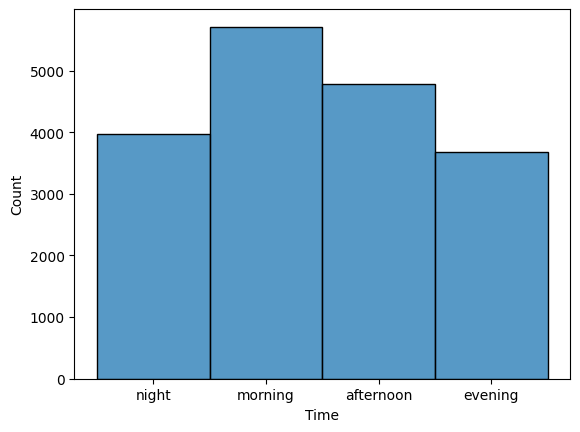

In [55]:
# Plotting a histogram to get the max delay occurs at a particular time of the day.
sns.histplot(df, x='Time')

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Most delay occurs in the evening followed by morning and afternoon, let's convert it to some categorical value, for this we will use <code>Ordinal Encoding</code>.
</p><br>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
<b>Ordinal Encoding:</b><br><br>
If the divisions of the day have some order (e.g., "Evening" &lt "Night" &lt "Afternoon" &lt "Morning"), you can use ordinal encoding to convert them into numerical values. This encoding preserves the ordinal relationship between the categories. However, be cautious as ordinal encoding may introduce a linear relationship between the divisions of the day, which may not reflect the actual relationship.</p>

In [56]:
# Ordinal Encoding
ordinalEncoder = OrdinalEncoder(categories=[['morning', 'afternoon', 'night', 'evening']])
encoded_data = ordinalEncoder.fit_transform(df[['Time']])
df['Time'] = encoded_data

In [57]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Month_sin,Month_cos
0,2.0,Sunday,MUSEUM,MUPAA,3,9,S,YU,0.5,0.866025
1,2.0,Sunday,KIPLING,MUIS,0,0,E,BD,0.5,0.866025
2,2.0,Sunday,WARDEN,SUO,0,0,W,BD,0.5,0.866025
3,2.0,Sunday,KEELE,MUIS,0,0,W,BD,0.5,0.866025
4,0.0,Sunday,BATHURST,MUIS,0,0,W,BD,0.5,0.866025


<br>

### _Day_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Day has all 7 days of the week and there's no null values. Also, days of the week follow a cyclical or periodic nature. So, we will again use the <code>Cyclical Encoding</code> to convert days into some continous value.  </p>

In [58]:
# Cyclical Encoding
df['Day_sin'] = np.sin(2 * np.pi * df.index / 7)
df['Day_cos'] = np.cos(2 * np.pi * df.index / 7)

# Dropping the Day column
df.drop(columns=['Day'], inplace=True)
df.head()

,Time,Station,Code,Min Delay,Min Gap,Bound,Line,Month_sin,Month_cos,Day_sin,Day_cos
0,2.0,MUSEUM,MUPAA,3,9,S,YU,0.5,0.866025,0.000000,1.000000
1,2.0,KIPLING,MUIS,0,0,E,BD,0.5,0.866025,0.781831,0.623490
2,2.0,WARDEN,SUO,0,0,W,BD,0.5,0.866025,0.974928,-0.222521
3,2.0,KEELE,MUIS,0,0,W,BD,0.5,0.866025,0.433884,-0.900969
4,0.0,BATHURST,MUIS,0,0,W,BD,0.5,0.866025,-0.433884,-0.900969


<br>

### _Station_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
Here there are 70 subway station, so to convert large number of categories to continous values, we will use Target Encoding to convert categorical data to continous values
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Target Encoding:</b><br>
    This technique replaces each category with the mean of the target variable for that category.
</p>
<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Let's implement the Target Encoding for our Station Feature
</p>

In [59]:
# Creating the Target Encoder object
target_encoder = TargetEncoder()

In [60]:
# Transforming the Station column
df['Station'] = target_encoder.fit_transform(df['Station'], df['Min Delay'])

In [61]:
df.head()

,Time,Station,Code,Min Delay,Min Gap,Bound,Line,Month_sin,Month_cos,Day_sin,Day_cos
0,2.0,3.786203,MUPAA,3,9,S,YU,0.5,0.866025,0.000000,1.000000
1,2.0,2.417790,MUIS,0,0,E,BD,0.5,0.866025,0.781831,0.623490
2,2.0,3.710997,SUO,0,0,W,BD,0.5,0.866025,0.974928,-0.222521
3,2.0,3.099432,MUIS,0,0,W,BD,0.5,0.866025,0.433884,-0.900969
4,0.0,1.722071,MUIS,0,0,W,BD,0.5,0.866025,-0.433884,-0.900969


### _Code_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Encoding Code column using Target Encoding
</p>

In [62]:
df['Code'] = target_encoder.fit_transform(df['Code'], df['Min Delay'])
df.head()

,Time,Station,Code,Min Delay,Min Gap,Bound,Line,Month_sin,Month_cos,Day_sin,Day_cos
0,2.0,3.786203,2.213600,3,9,S,YU,0.5,0.866025,0.000000,1.000000
1,2.0,2.417790,0.080596,0,0,E,BD,0.5,0.866025,0.781831,0.623490
2,2.0,3.710997,1.992795,0,0,W,BD,0.5,0.866025,0.974928,-0.222521
3,2.0,3.099432,0.080596,0,0,W,BD,0.5,0.866025,0.433884,-0.900969
4,0.0,1.722071,0.080596,0,0,W,BD,0.5,0.866025,-0.433884,-0.900969


### _Bound_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Encoding Code column using OneHot encoding
</p>

In [63]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
transformed = one_hot_encoder.fit_transform(df[['Bound']])

#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(transformed, columns=one_hot_encoder.get_feature_names_out())
#concat with original data
df = pd.concat([df, ohe_df], axis=1).drop(['Bound'], axis=1)
df.head()

,Time,Station,Code,Min Delay,Min Gap,Line,Month_sin,Month_cos,Day_sin,Day_cos,Bound_E,Bound_N,Bound_S,Bound_W
0,2.0,3.786203,2.213600,3,9,YU,0.5,0.866025,0.000000,1.000000,0.0,0.0,1.0,0.0
1,2.0,2.417790,0.080596,0,0,BD,0.5,0.866025,0.781831,0.623490,1.0,0.0,0.0,0.0
2,2.0,3.710997,1.992795,0,0,BD,0.5,0.866025,0.974928,-0.222521,0.0,0.0,0.0,1.0
3,2.0,3.099432,0.080596,0,0,BD,0.5,0.866025,0.433884,-0.900969,0.0,0.0,0.0,1.0
4,0.0,1.722071,0.080596,0,0,BD,0.5,0.866025,-0.433884,-0.900969,0.0,0.0,0.0,1.0


### _Line_ Feature

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    Encoding Line column using OneHot encoding
</p>

In [64]:
# Transforming the Line column
transformed = one_hot_encoder.fit_transform(df['Line'].to_numpy().reshape(-1, 1))

# Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(transformed, columns=one_hot_encoder.get_feature_names_out())

#concat with original data
df = pd.concat([df, ohe_df], axis=1).drop(['Line'], axis=1)

# renaming column names
df.rename(columns={'x0_BD': 'BD', 'x0_YU': 'YU'}, inplace=True)
df.head()

,Time,Station,Code,Min Delay,Min Gap,Month_sin,Month_cos,Day_sin,Day_cos,Bound_E,Bound_N,Bound_S,Bound_W,BD,YU
0,2.0,3.786203,2.213600,3,9,0.5,0.866025,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,2.417790,0.080596,0,0,0.5,0.866025,0.781831,0.623490,1.0,0.0,0.0,0.0,1.0,0.0
2,2.0,3.710997,1.992795,0,0,0.5,0.866025,0.974928,-0.222521,0.0,0.0,0.0,1.0,1.0,0.0
3,2.0,3.099432,0.080596,0,0,0.5,0.866025,0.433884,-0.900969,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.722071,0.080596,0,0,0.5,0.866025,-0.433884,-0.900969,0.0,0.0,0.0,1.0,1.0,0.0


In [65]:
# Saving the encoded data to csv file
df.to_csv('encoded_ttc_subway.csv', index=False)

# Relation Analysis

### Plotting the relation between Independent and Dependent variables

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    To identify the best feature we need to plot the coorelation between each independent and dependent variables.
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Time vs Min Delay
</p>

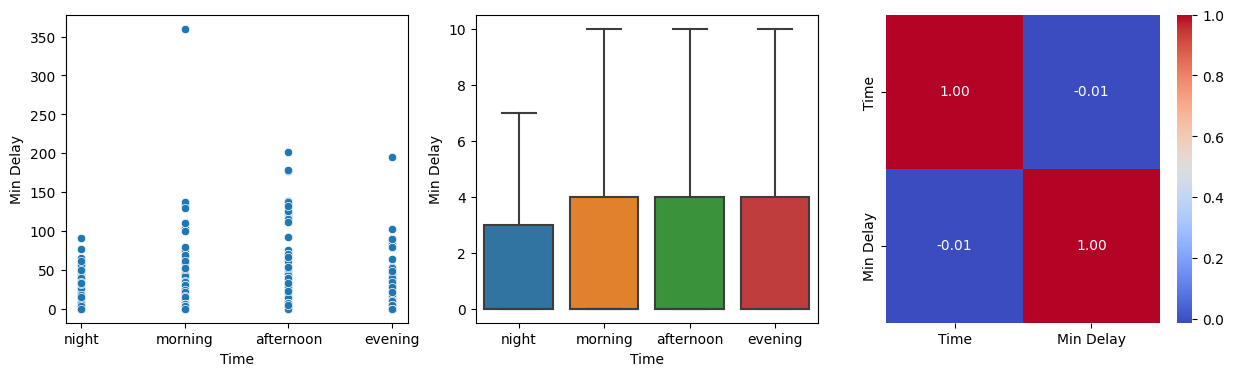

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.scatterplot(df1, x='Time', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Time', y='Min Delay', ax=axes[1], showfliers=False)

corr_matrix = df[['Time', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Day vs Min Delay
</p>

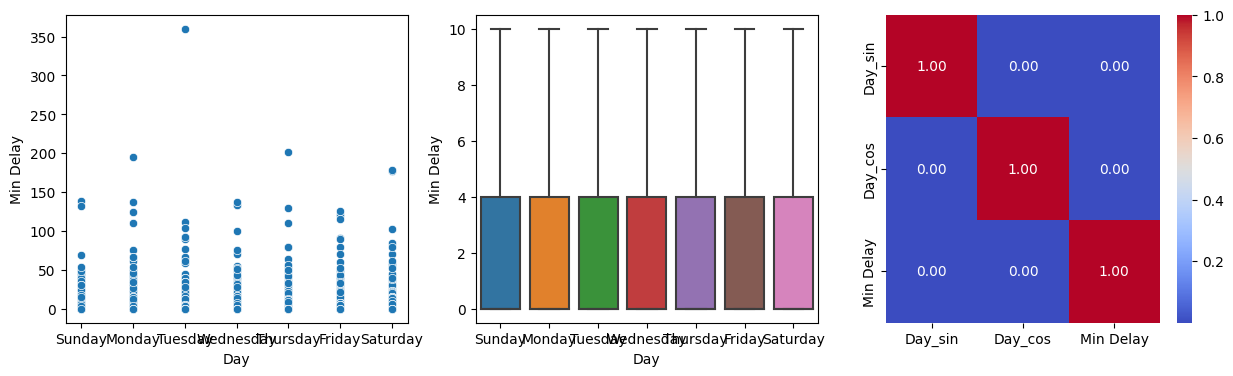

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.scatterplot(df1, x='Day', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Day', y='Min Delay', ax=axes[1], showfliers=False, fliersize=0)

corr_matrix = df[['Day_sin', 'Day_cos', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Station vs Min Delay
</p>

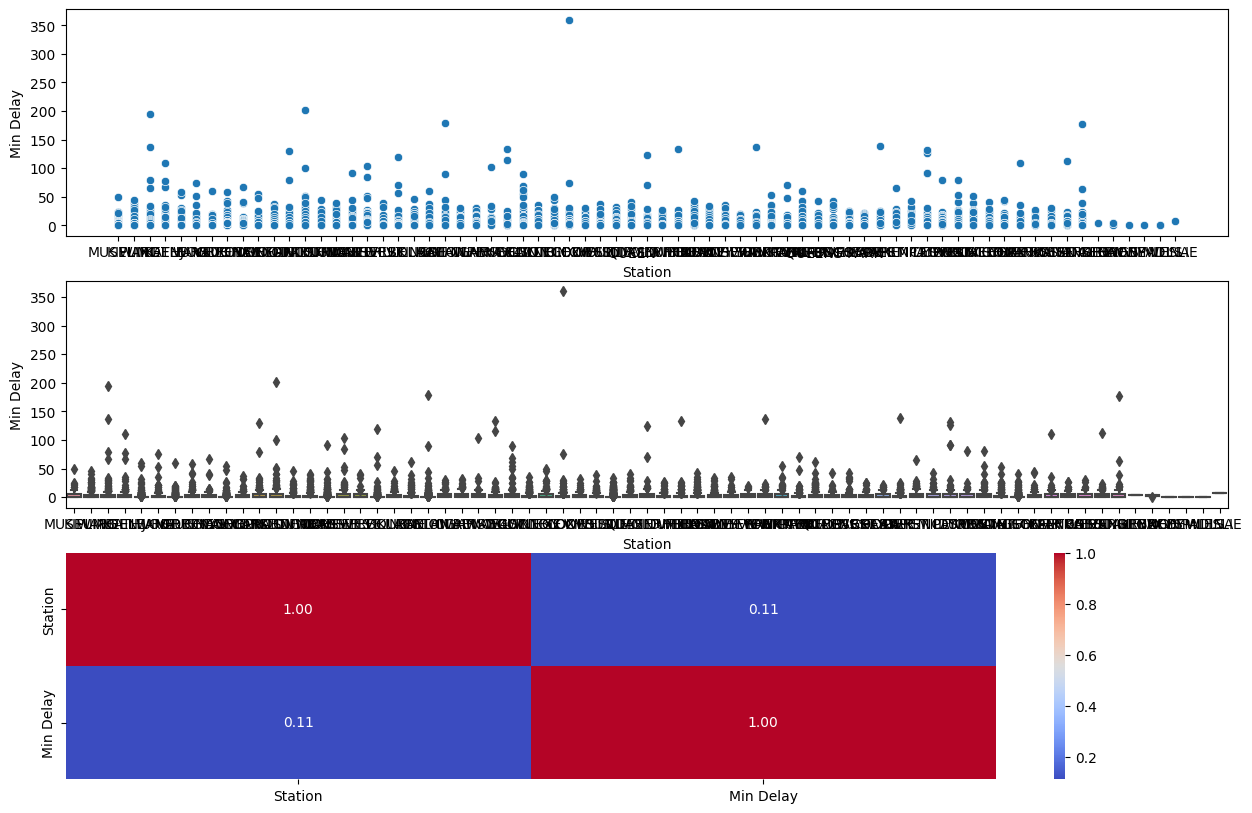

In [68]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
sns.scatterplot(df1, x='Station', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Station', y='Min Delay', ax=axes[1])

corr_matrix = df[['Station', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Code vs Min Delay
</p>

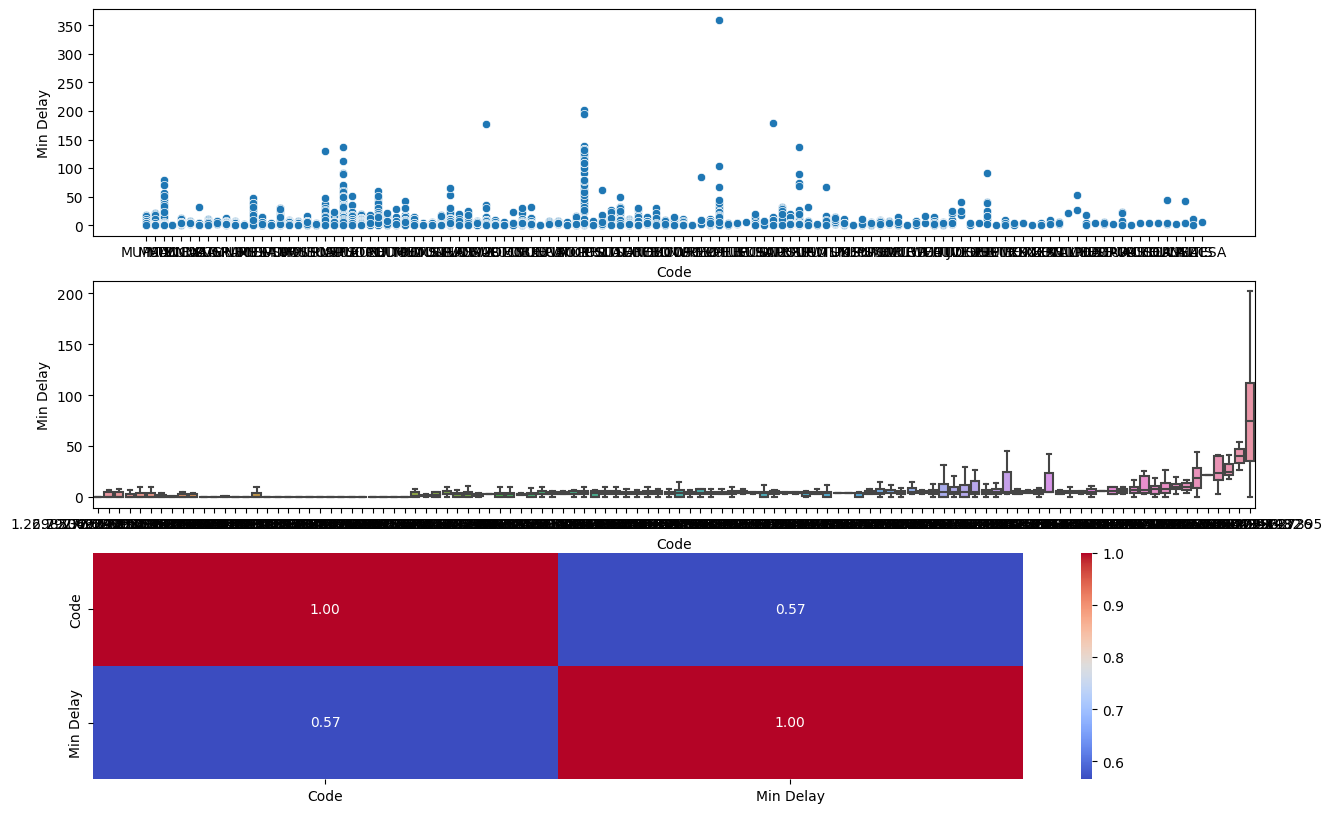

In [69]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
sns.scatterplot(df1, x='Code', y='Min Delay', ax=axes[0])

grouped = df[['Code', 'Min Delay']].groupby(['Code']).median()
sorted_values = grouped.sort_values(by='Min Delay')
sns.boxplot(df, x='Code', y='Min Delay', ax=axes[1], fliersize=0, showfliers=False, order=sorted_values.index)
# sns.boxplot(df1, x='Code', y='Min Delay', ax=axes[1], fliersize=0, showfliers=False)

corr_matrix = df[['Code', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<Axes: xlabel='Code', ylabel='Min Delay'>

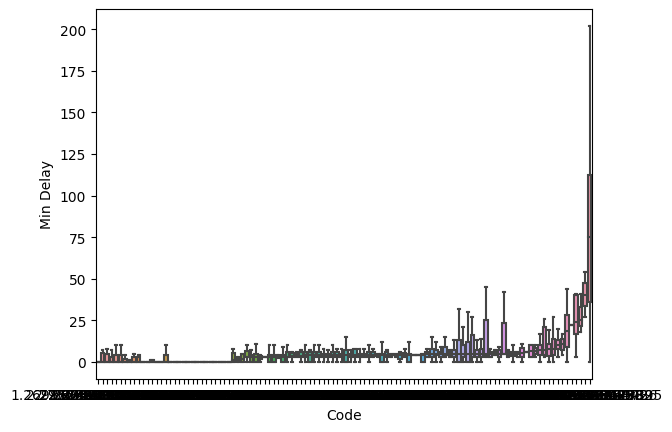

In [70]:
grouped = df[['Code', 'Min Delay']].groupby(['Code']).median()
sorted_values = grouped.sort_values(by='Min Delay')
sns.boxplot(df, x='Code', y='Min Delay', fliersize=0, showfliers=False, order=sorted_values.index)

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Min Gap vs Min Delay
</p>

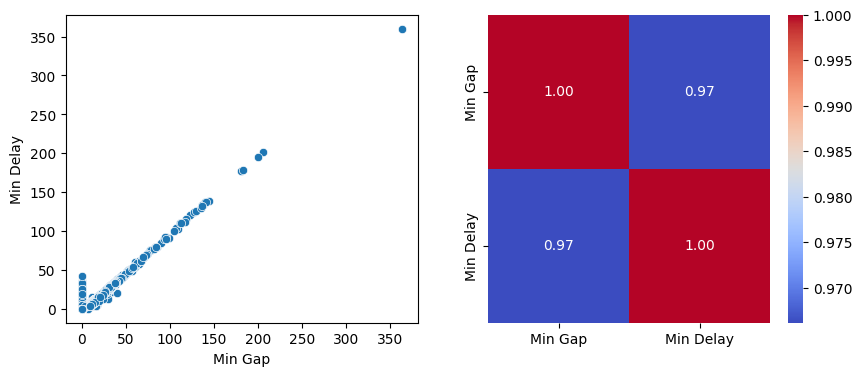

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(df1, x='Min Gap', y='Min Delay', ax=axes[0])

corr_matrix = df[['Min Gap', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Bound vs Min Delay
</p>

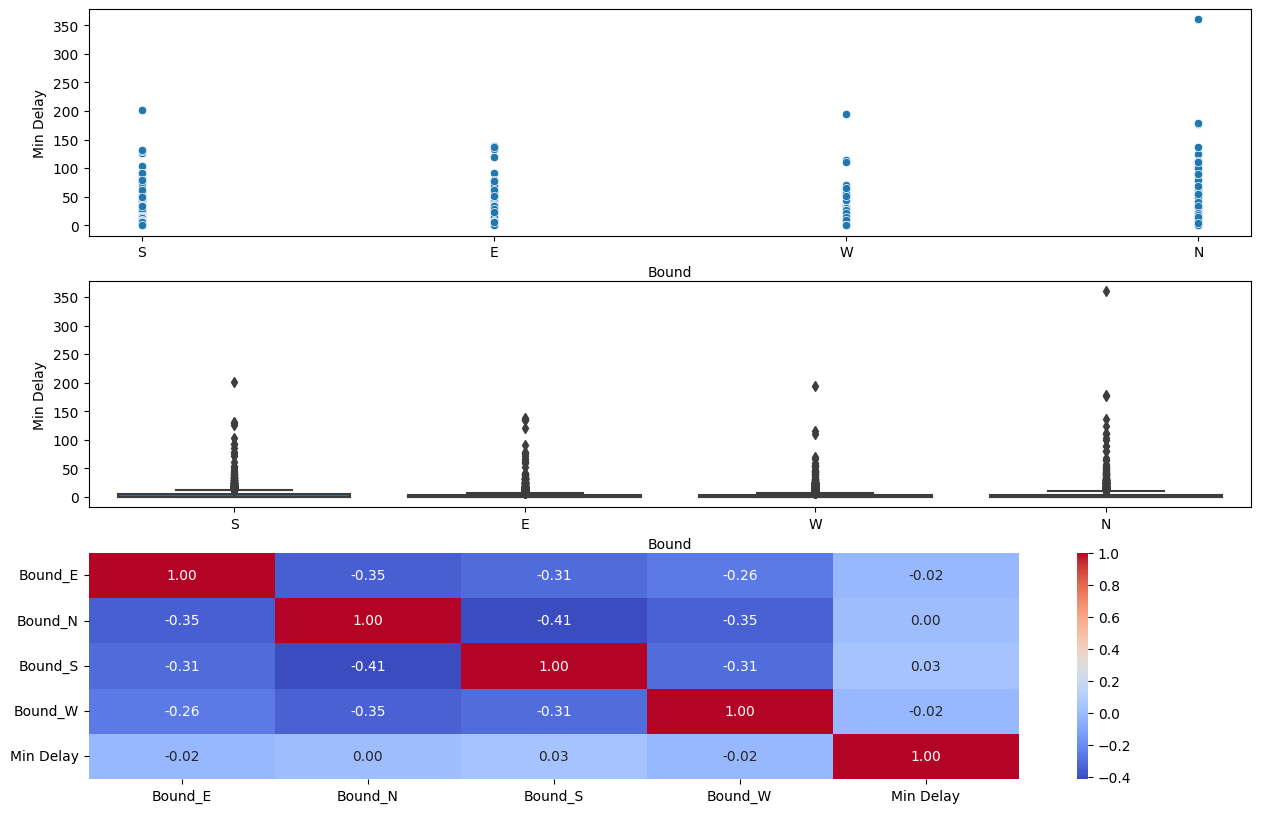

In [72]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
sns.scatterplot(df1, x='Bound', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Bound', y='Min Delay', ax=axes[1])

corr_matrix = df[['Bound_E', 'Bound_N', 'Bound_S', 'Bound_W', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Line vs Min Delay
</p>

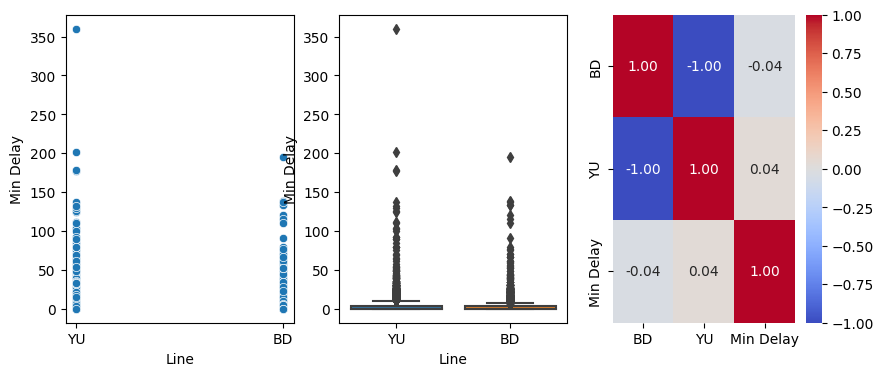

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
sns.scatterplot(df1, x='Line', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Line', y='Min Delay', ax=axes[1])

corr_matrix = df[['BD', 'YU', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    <b>Month vs Min Delay
</p>

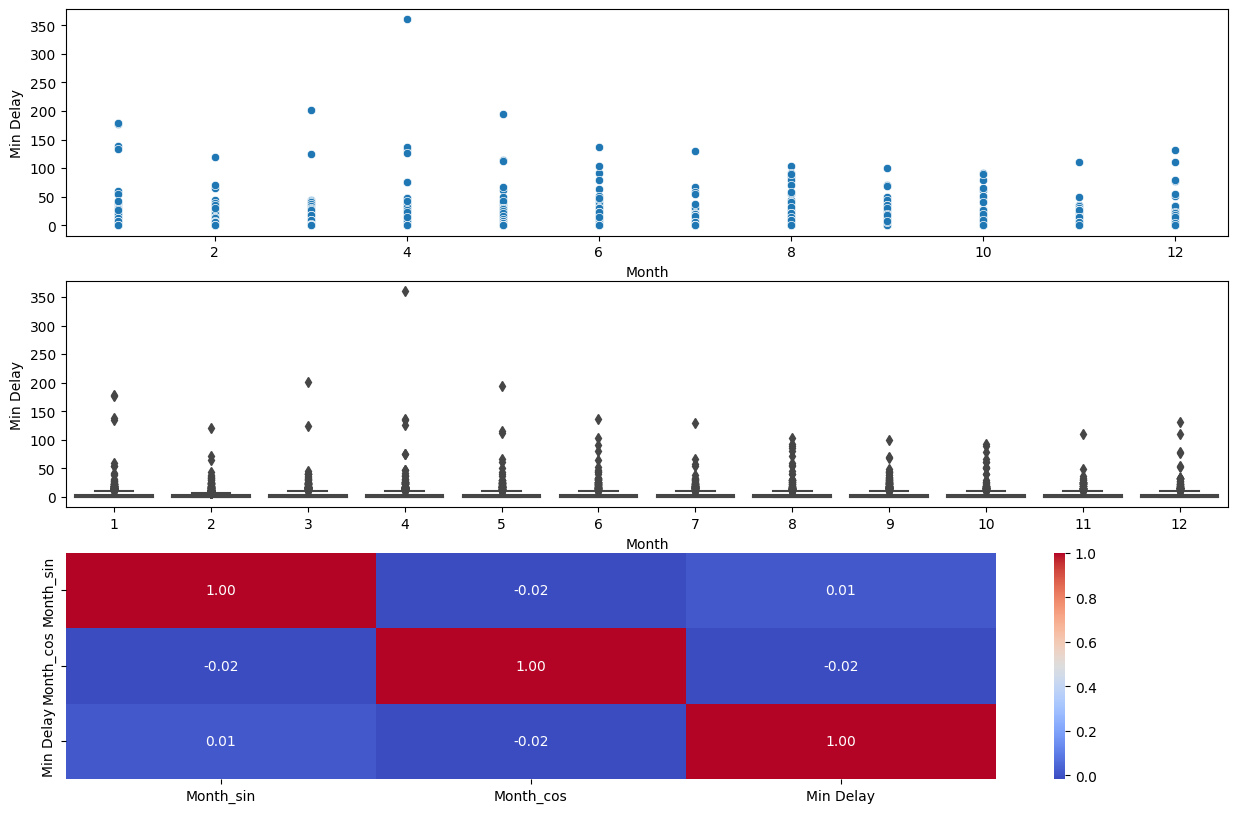

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
sns.scatterplot(df1, x='Month', y='Min Delay', ax=axes[0])
sns.boxplot(df1, x='Month', y='Min Delay', ax=axes[1])

corr_matrix = df[['Month_sin', 'Month_cos', 'Min Delay']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
plt.show()

<br><p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    From the plots above we can conclude that only <code>Min Gap</code> &amp; <code>Code</code> are the features who has good corelation with the dependent variable <code>Min Delay</code>.
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    So we will proceed with <code>Min Gap</code> &amp; <code>Code</code> to build our regression models.
</p>

<br>

# Regression Model

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    For building the regression model we will use <code>SGDRegressor()</code> class instead of using LinearRegression().
</p>

<p style="font-size: 17px; letter-spacing:1px; font-family: 'Charter', Times, serif;">
    The reason behind choosing <i>SGDRegressor</i> over <i>LinearRegression</i>:<br>
    - It uses Stochastic Gradient Descent to derive the parameters. While LinearRegression uses OLS method.<br>
    - It uses Regularization by default when deriving the parameters while LinearRegression doesn't use.
</p>    

In [75]:
df_features = df[['Code', 'Min Gap']]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df['Min Delay'], test_size=0.2, random_state=42)

In [77]:
# Initializing the SGDRegressor object
sgd = SGDRegressor()

sgd.fit(X_train, y_train)

print(f"Coefficients: {sgd.coef_}")
print(f"Intercept: {sgd.intercept_}")

Yhat = sgd.predict(X_test)

print(f"Score: {sgd.score(X_test, y_test)}")

mse = mean_squared_error(y_test, Yhat)
print(f"MSE: {mse}")

Coefficients: [-0.02272379  0.85648892]
Intercept: [-0.57341977]
Score: 0.9108263704514475
MSE: 4.12189955408169


# Saving Model Files

In [78]:
# Saving the trained model
joblib.dump(sgd, 'model/ttc-subway-delay-model.pkl') 

['predictions/ttc-subway-delay-model.pkl']